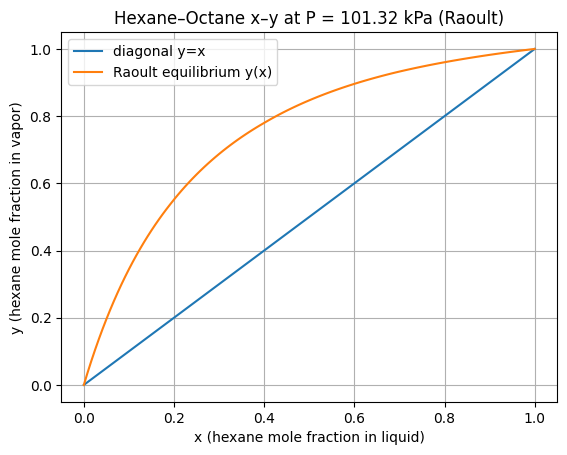

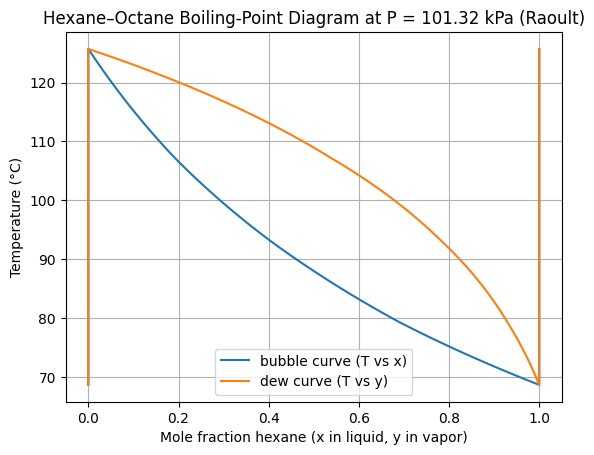

   x_hexane      y_hexane      T_bubble_C
    0.0000      0.0000      68.7000
    0.0917      0.3221     116.0292
    0.1917      0.5377     107.2299
    0.3000      0.6873      99.5052
    0.4000      0.7799      93.3503
    0.5000      0.8471      88.0236
    0.6000      0.8960      83.2464
    0.7000      0.9326      78.9510
    0.8083      0.9624      74.9359
    0.9083      0.9840      71.5622
    1.0000      1.0000     125.7000


In [ ]:
# notebooks/26.1_3.py

import sys
import math
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")

from bank.Distillation.distillation_vle_raoult_antoine_base import (
    K_from_Psat,
    y_from_xK,
)

# -----------------------
# Given data
# -----------------------
P_total = 101.32  # kPa

T_C = np.array([68.7, 79.4, 93.3, 107.2, 125.7], dtype=float)

Psat_hex_kPa = np.array([101.3, 136.7, 197.3, 284.0, 456.0], dtype=float)   # n-hexane
Psat_oct_kPa = np.array([16.1,  23.1,  37.1,  57.9, 101.3], dtype=float)   # n-octane

if not (len(T_C) == len(Psat_hex_kPa) == len(Psat_oct_kPa) >= 2):
    raise ValueError("Bad table lengths.")

# -----------------------
# Psat(T): log-linear interpolation/extrapolation in ln(P) vs T
# -----------------------
def psat_loglinear_extrap(T: float, T_grid: np.ndarray, P_grid: np.ndarray) -> float:
    """
    Piecewise log-linear interpolation in ln(P) vs T, with linear extrapolation
    beyond the table using the nearest segment.
    """
    Tg = T_grid
    Pg = P_grid

    if T <= float(Tg[0]):
        i = 0
    elif T >= float(Tg[-1]):
        i = len(Tg) - 2
    else:
        i = int(np.searchsorted(Tg, T) - 1)

    Ta, Tb = float(Tg[i]), float(Tg[i + 1])
    Pa, Pb = float(Pg[i]), float(Pg[i + 1])

    lnPa, lnPb = math.log(Pa), math.log(Pb)
    w = (T - Ta) / (Tb - Ta)
    lnP = lnPa + w * (lnPb - lnPa)
    return math.exp(lnP)


def K_of_T(T: float) -> list[float]:
    Psat_hex = psat_loglinear_extrap(T, T_C, Psat_hex_kPa)
    Psat_oct = psat_loglinear_extrap(T, T_C, Psat_oct_kPa)
    return K_from_Psat([Psat_hex, Psat_oct], P_total)


# -----------------------
# Bubble residual and robust bracketing
# -----------------------
def bubble_residual_at_T(T: float, x_hex: float) -> float:
    # bubble: sum x_i K_i(T) - 1 = 0
    K = K_of_T(T)
    return x_hex * K[0] + (1.0 - x_hex) * K[1] - 1.0


def bracket_root_for_x(x_hex: float,
                       T_center: float,
                       dT0: float = 2.0,
                       expand: float = 1.6,
                       max_expand: int = 80) -> tuple[float, float]:
    """
    Find [T_lo, T_hi] such that bubble_residual(T_lo)*bubble_residual(T_hi) <= 0.
    Expands symmetrically about T_center.
    """
    dT = float(dT0)
    lo = T_center - dT
    hi = T_center + dT
    flo = bubble_residual_at_T(lo, x_hex)
    fhi = bubble_residual_at_T(hi, x_hex)

    for _ in range(max_expand):
        if flo == 0.0:
            return lo, lo
        if fhi == 0.0:
            return hi, hi
        if flo * fhi < 0.0:
            return lo, hi
        dT *= expand
        lo = T_center - dT
        hi = T_center + dT
        flo = bubble_residual_at_T(lo, x_hex)
        fhi = bubble_residual_at_T(hi, x_hex)

    raise ValueError("Failed to bracket bubble-point root; check Psat data/range.")


def bisection(fn, a: float, b: float, tol: float = 1e-10, maxiter: int = 250) -> float:
    fa = fn(a)
    fb = fn(b)
    if fa == 0.0:
        return a
    if fb == 0.0:
        return b
    if fa * fb > 0.0:
        raise ValueError("Bisection requires sign change.")
    lo, hi = a, b
    flo, fhi = fa, fb
    for _ in range(maxiter):
        mid = 0.5 * (lo + hi)
        fm = fn(mid)
        if abs(fm) <= tol:
            return mid
        if flo * fm <= 0.0:
            hi, fhi = mid, fm
        else:
            lo, flo = mid, fm
    return 0.5 * (lo + hi)


# -----------------------
# (a) x–y data at P_total
# -----------------------
x_grid = np.linspace(1e-6, 1.0 - 1e-6, 121)

T_bub = np.zeros_like(x_grid)
y_grid = np.zeros_like(x_grid)

# use table midpoint as initial bracket center
T_center0 = float(0.5 * (T_C[0] + T_C[-1]))

for k, x in enumerate(x_grid):
    # robust per-x bracket
    T_lo, T_hi = bracket_root_for_x(x, T_center=T_center0)

    # solve bubble-point temperature
    T = bisection(lambda TT: bubble_residual_at_T(TT, x), T_lo, T_hi, tol=1e-10, maxiter=300)

    K_T = K_of_T(T)
    y = y_from_xK([x, 1.0 - x], K_T)[0]

    T_bub[k] = T
    y_grid[k] = y

# Add endpoints (pure components) by using the table’s normal-bp points at 101.3 kPa
x_plot = np.concatenate(([0.0], x_grid, [1.0]))
y_plot = np.concatenate(([0.0], y_grid, [1.0]))
T_plot = np.concatenate(([float(T_C[0])], T_bub, [float(T_C[-1])]))

# -----------------------
# Plot 1: x–y diagram
# -----------------------
plt.figure()
plt.plot([0.0, 1.0], [0.0, 1.0], label="diagonal y=x")
plt.plot(x_plot, y_plot, label="Raoult equilibrium y(x)")
plt.xlabel("x (hexane mole fraction in liquid)")
plt.ylabel("y (hexane mole fraction in vapor)")
plt.title("Hexane–Octane x–y at P = 101.32 kPa (Raoult)")
plt.grid(True)
plt.legend()
plt.show()

# -----------------------
# (b) Boiling-point diagram (T–x–y)
# -----------------------
plt.figure()
plt.plot(x_plot, T_plot, label="bubble curve (T vs x)")
plt.plot(y_plot, T_plot, label="dew curve (T vs y)")
plt.xlabel("Mole fraction hexane (x in liquid, y in vapor)")
plt.ylabel("Temperature (°C)")
plt.title("Hexane–Octane Boiling-Point Diagram at P = 101.32 kPa (Raoult)")
plt.grid(True)
plt.legend()
plt.show()

# -----------------------
# Optional: coarse table
# -----------------------
idx = np.linspace(0, len(x_plot) - 1, 11).round().astype(int)
print("   x_hexane      y_hexane      T_bubble_C")
for i in idx:
    print(f"{x_plot[i]:10.4f}  {y_plot[i]:10.4f}  {T_plot[i]:11.4f}")